Author: <font color="blue">Josep Monclús Carrasco</font>

E-mail: <font color="blue">josep.monclus01@estudiant.upf.edu</font>

Date: <font color="blue">05/11/2021</font>

In [3]:
#!pip install wordcloud

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd   
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [2]:
# Leave this code as-is
#I change the file path adding data/
FILENAME_RATINGS = "data/ratings.dat"
FILENAME_USERS = "data/users.dat"
FILENAME_MOVIES = "data/movies.dat"

In [3]:
# Leave this code as-is

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep='::', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

users = pd.read_csv(FILENAME_USERS, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
users.set_index('user_id')

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
movies.set_index('movie_id')

,title,genres
movie_id,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy
...,...,...
3948,Meet the Parents (2000),Comedy
3949,Requiem for a Dream (2000),Drama
3950,Tigerland (2000),Drama


In [8]:
print("Rows on the file ratings.dat:",ratings_raw.shape[0])
print("Rows on the file users.dat:",users.shape[0])
print("Rows on the file movies.dat:",movies.shape[0])

Rows on the file ratings.dat: 1000209
Rows on the file users.dat: 6040
Rows on the file movies.dat: 3883


In [9]:
ratings_raw.head(5)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
users.head(5)

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [11]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


On the ratings_raw table, the 'user_id' column is a foreing key from the table users, so this is the column that we are going to use for merge the tables. With movies we have the same but with the column 'movie_id' so we are going to do the same process.

In [12]:
ratings_r = pd.merge(ratings_raw,users,on="user_id")
ratings = pd.merge(ratings_r,movies,on="movie_id")
ratings.head(5)

,user_id,movie_id,rating,timestamp,gender,age,occupation,zipcode,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [13]:
import re
def find_movies(tit,movies):
    inds = []
    for i,mov in enumerate(movies.title):
        if re.search(tit,mov):
            inds.append(i)
    movs = movies.iloc[inds]
    return movs
find_movies("Godfather", movies)

,movie_id,title,genres
847,858,"Godfather, The (1972)",Action|Crime|Drama
1203,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama
1954,2023,"Godfather: Part III, The (1990)",Action|Crime|Drama


# 2. Exploratory Data Analysis

## 2.1. "Ratings" variable

In [14]:
# Leave this code as-is
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

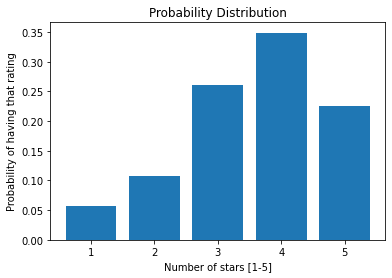

In [18]:
freq = []
#We calculate the probability
for i in range(1,6):
    freq.append(len(ratings.rating[ratings.rating == i])/len(ratings.rating))
plt.bar([1,2,3,4,5],freq)
plt.xlabel("Number of stars [1-5]")
plt.title("Probability Distribution")
plt.ylabel("Probability of having that rating")
plt.show()

As we can see the people tend to put better ratings than bad ratings, as it showed in the distribution, 3 and 4 are the most probable ratings for a film, followed by 5 stars.

## 2.2. Gender differences in rating

In [19]:
ratings_male = ratings[ratings.gender == "M"]
ratings_female = ratings[ratings.gender == "F"]
ratings_male = ratings_male.groupby("title").rating.agg(["count","mean"])
ratings_female = ratings_female.groupby("title").rating.agg(["count","mean"])
ratings_male = ratings_male.rename(columns={'count': 'ratings_count_m', 'mean': 'ratings_mean_m'})
ratings_female = ratings_female.rename(columns={'count': 'ratings_count_f', 'mean': 'ratings_mean_f'})

ratings_gender = pd.merge(ratings_male, ratings_female, how='inner', on='title')
ratings_gender = ratings_gender[(ratings_gender['ratings_count_m'] > 100) & (ratings_gender['ratings_count_f'] > 100)]

ratings_gender = pd.merge(ratings_gender,movies,on="title")
ratings_gender = ratings_gender.drop(columns=["movie_id"],axis=1)
ratings_gender["abs_diff"] = abs(ratings_gender["ratings_mean_m"] - ratings_gender["ratings_mean_f"])

ratings_gender = ratings_gender.sort_values(by='abs_diff', ascending=False)

ratings_gender.head(5)


,title,ratings_count_m,ratings_mean_m,ratings_count_f,ratings_mean_f,genres,abs_diff
208,Dirty Dancing (1987),396,2.959596,291,3.790378,Musical|Romance,0.830782
393,Jumpin' Jack Flash (1986),268,2.578358,106,3.254717,Action|Comedy|Romance|Thriller,0.676359
225,Dumb & Dumber (1994),511,3.336595,149,2.697987,Comedy,0.638608
323,Grease (1978),534,3.367041,283,3.975265,Comedy|Musical|Romance,0.608224
132,Caddyshack (1980),760,3.969737,207,3.396135,Comedy,0.573602


As we can see with the 2 first films Dirty Dancing was in the past a film for "female consumers" (Musical, Romance) and the ratings are hight in this strata of population, and the inverse with Dumb & Dumber (1994)(Comedy). I think this can explain the bais that educational we continue having.

## 2.3. Genres distribution

In [22]:
#We create a dictionary to store the genre and its frequency
keyword_occurences = dict()
for gen in movies['genres']:
    genres = gen.split("|")
    for genre in genres:
        if genre not in keyword_occurences:
            keyword_occurences[genre] = 1
        else:
            keyword_occurences[genre] += 1

In [23]:
for key in keyword_occurences.keys():
    print(key,keyword_occurences[key])
print("Total genres:",len(keyword_occurences.keys()))

Animation 105
Children's 251
Comedy 1200
Adventure 283
Fantasy 68
Romance 471
Drama 1603
Action 503
Crime 211
Thriller 492
Horror 343
Sci-Fi 276
Documentary 127
War 143
Musical 114
Mystery 106
Film-Noir 44
Western 68
Total genres: 18


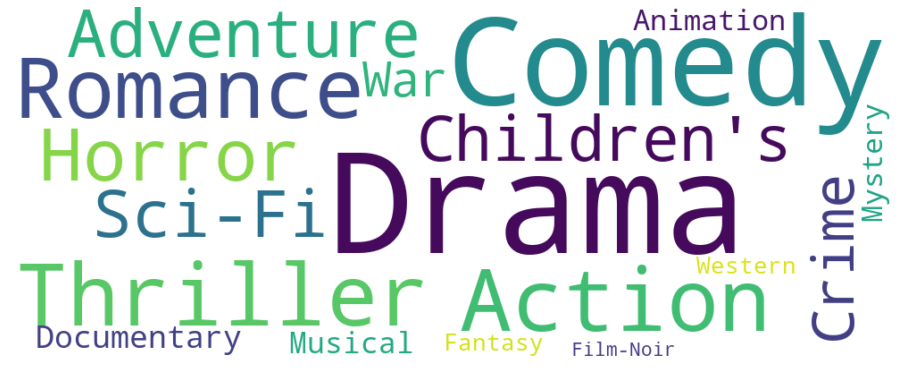

In [24]:
# Change the colors/style if you want

# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(keyword_occurences))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In this plot we can see the different genres frequency represented by color and size depending on the frequency value. As we can see the most frequent genre is Drama, followed by Comedy, and that's is why the 2 titles are bigger.

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

In [25]:
genres_arr = []
movies['genres'].fillna('').astype('str')
for gen in movies['genres']:
    genres = gen.split("|")
    genres_arr.append(genres)
movies["genres_arr"] = genres_arr

In [26]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][0], movies['genres_arr'][0]))

Transformed: Animation|Children's|Comedy → ['Animation', "Children's", 'Comedy']


In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
genres = []
for gens_ar in movies["genres_arr"]:
    genres.append(" ".join(gens_ar))
#We apply the TfidfVectorizer to the genres
tfidf_matrix = vectorizer.fit_transform(genres)
print(tfidf_matrix.shape)

(3883, 127)


## 3.2. Calculate most similar movies

In [29]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.14193614 0.09010857 ... 0.         0.         0.        ]
 [0.14193614 1.         0.         ... 0.         0.         0.        ]
 [0.09010857 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         1.         0.3165589 ]
 [0.         0.         0.         ... 1.         1.         0.3165589 ]
 [0.         0.         0.         ... 0.3165589  0.3165589  1.        ]]


In [30]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies.index, index=movies['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies.iloc[index_target].movie_id, movies.iloc[index_target].title))
        
print_similarity_vector(1, cosine_sim)

1.000 1 Toy Story (1995)
0.142 2 Jumanji (1995)
0.090 3 Grumpier Old Men (1995)
0.106 4 Waiting to Exhale (1995)
0.235 5 Father of the Bride Part II (1995)
0.000 6 Heat (1995)
0.090 7 Sabrina (1995)
0.210 8 Tom and Huck (1995)
0.000 9 Sudden Death (1995)
0.000 10 GoldenEye (1995)
0.073 11 American President, The (1995)
0.074 12 Dracula: Dead and Loving It (1995)
0.827 13 Balto (1995)
0.000 14 Nixon (1995)
0.000 15 Cutthroat Island (1995)
0.000 16 Casino (1995)
0.000 17 Sense and Sensibility (1995)
0.000 18 Four Rooms (1995)
0.235 19 Ace Ventura: When Nature Calls (1995)
0.000 20 Money Train (1995)
0.065 21 Get Shorty (1995)
0.000 22 Copycat (1995)
0.000 23 Assassins (1995)
0.000 24 Powder (1995)
0.000 25 Leaving Las Vegas (1995)
0.000 26 Othello (1995)
0.000 27 Now and Then (1995)
0.000 28 Persuasion (1995)
0.000 29 City of Lost Children, The (1995)
0.000 30 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
0.000 31 Dangerous Minds (1995)
0.000 32 Twelve Monkeys (1995)
0.000 33 Wing

0.106 583 Dear Diary (Caro Diario) (1994)
0.000 584 I Don't Want to Talk About It (De eso no se habla) (1993)
0.235 585 Brady Bunch Movie, The (1995)
0.693 586 Home Alone (1990)
0.059 587 Ghost (1990)
0.789 588 Aladdin (1992)
0.000 589 Terminator 2: Judgment Day (1991)
0.000 590 Dances with Wolves (1990)
0.000 591 Tough and Deadly (1995)
0.000 592 Batman (1989)
0.000 593 Silence of the Lambs, The (1991)
0.589 594 Snow White and the Seven Dwarfs (1937)
0.589 595 Beauty and the Beast (1991)
0.827 596 Pinocchio (1940)
0.090 597 Pretty Woman (1990)
0.235 598 Window to Paris (1994)
0.000 599 Wild Bunch, The (1969)
0.000 600 Love and a .45 (1994)
0.000 601 Wooden Man's Bride, The (Wu Kui) (1994)
0.000 602 Great Day in Harlem, A (1994)
0.235 603 Bye Bye, Love (1995)
0.000 604 Criminals (1996)
0.000 605 One Fine Day (1996)
0.000 606 Candyman: Farewell to the Flesh (1995)
0.000 607 Century (1993)
0.000 608 Fargo (1996)
0.210 609 Homeward Bound II: Lost in San Francisco (1996)
0.143 610 Heavy Me

0.000 1049 Ghost and the Darkness, The (1996)
0.000 1050 Looking for Richard (1996)
0.000 1051 Trees Lounge (1996)
0.000 1052 Proprietor, The (1996)
0.000 1053 Normal Life (1996)
0.000 1054 Get on the Bus (1996)
0.000 1055 Shadow Conspiracy (1997)
0.000 1056 Jude (1996)
0.050 1057 Everyone Says I Love You (1996)
0.000 1058 Bitter Sugar (Azucar Amargo) (1996)
0.000 1059 William Shakespeare's Romeo and Juliet (1996)
0.106 1060 Swingers (1996)
0.000 1061 Sleepers (1996)
0.000 1062 Sunchaser, The (1996)
0.000 1063 Johns (1996)
1.000 1064 Aladdin and the King of Thieves (1996)
0.000 1065 Woman in Question, The (1950)
0.050 1066 Shall We Dance? (1937)
0.050 1067 Damsel in Distress, A (1937)
0.000 1068 Crossfire (1947)
0.000 1069 Murder, My Sweet (1944)
0.000 1070 Macao (1952)
0.000 1071 For the Moment (1994)
0.369 1073 Willy Wonka and the Chocolate Factory (1971)
0.235 1075 Sexual Life of the Belgians, The (1994)
0.000 1076 Innocents, The (1961)
0.057 1077 Sleeper (1973)
0.062 1078 Bananas (

0.210 1538 Second Jungle Book: Mowgli & Baloo, The (1997)
0.071 1539 Twin Town (1997)
0.090 1541 Addicted to Love (1997)
0.073 1542 Brassed Off (1996)
0.000 1543 Designated Mourner, The (1997)
0.000 1544 Lost World: Jurassic Park, The (1997)
0.000 1545 Ponette (1996)
0.235 1546 Schizopolis (1996)
0.205 1547 Shiloh (1997)
0.000 1548 War at Home, The (1996)
0.000 1549 Rough Magic (1995)
0.090 1550 Trial and Error (1997)
0.158 1551 Buddy (1997)
0.000 1552 Con Air (1997)
0.235 1553 Late Bloomers (1996)
0.000 1554 Pillow Book, The (1995)
0.000 1555 To Have, or Not (1995)
0.000 1556 Speed 2: Cruise Control (1997)
0.000 1557 Squeeze (1996)
0.235 1558 Sudden Manhattan (1996)
0.000 1559 Next Step, The (1995)
0.235 1561 Wedding Bell Blues (1996)
0.000 1562 Batman & Robin (1997)
0.000 1563 Dream With the Fishes (1997)
0.090 1564 Roseanna's Grave (For Roseanna) (1997)
0.067 1565 Head Above Water (1996)
0.665 1566 Hercules (1997)
0.000 1567 Last Time I Committed Suicide, The (1997)
0.000 1568 MURDE

0.000 2020 Dangerous Liaisons (1988)
0.000 2021 Dune (1984)
0.000 2022 Last Temptation of Christ, The (1988)
0.000 2023 Godfather: Part III, The (1990)
0.000 2024 Rapture, The (1991)
0.000 2025 Lolita (1997)
0.000 2026 Disturbing Behavior (1998)
0.071 2027 Mafia! (1998)
0.000 2028 Saving Private Ryan (1998)
0.090 2029 Billy's Hollywood Screen Kiss (1997)
0.000 2030 East Palace West Palace (Dong gong xi gong) (1997)
0.693 2031 $1,000,000 Duck (1971)
0.693 2032 Barefoot Executive, The (1971)
0.827 2033 Black Cauldron, The (1985)
0.000 2034 Black Hole, The (1979)
0.693 2035 Blackbeard's Ghost (1968)
0.693 2036 Blank Check (1994)
0.499 2037 Candleshoe (1977)
0.409 2038 Cat from Outer Space, The (1978)
0.210 2039 Cheetah (1989)
0.693 2040 Computer Wore Tennis Shoes, The (1970)
0.428 2041 Condorman (1981)
0.693 2042 D2: The Mighty Ducks (1994)
0.142 2043 Darby O'Gill and the Little People (1959)
0.235 2044 Devil and Max Devlin, The (1981)
0.139 2045 Far Off Place, A (1993)
0.125 2046 Flight 

0.000 2438 Outside Ozona (1998)
0.000 2439 Affliction (1997)
0.000 2440 Another Day in Paradise (1998)
0.000 2441 Hi-Lo Country, The (1998)
0.000 2442 Hilary and Jackie (1998)
0.000 2443 Playing by Heart (1998)
0.106 2444 24 7: Twenty Four Seven (1997)
0.000 2445 At First Sight (1999)
0.000 2446 In Dreams (1999)
0.106 2447 Varsity Blues (1999)
0.000 2448 Virus (1999)
0.210 2449 Garbage Pail Kids Movie, The (1987)
0.125 2450 Howard the Duck (1986)
0.000 2451 Gate, The (1987)
0.000 2452 Gate II: Trespassers, The (1990)
0.000 2453 Boy Who Could Fly, The (1986)
0.000 2454 Fly, The (1958)
0.000 2455 Fly, The (1986)
0.000 2456 Fly II, The (1989)
0.078 2457 Running Scared (1986)
0.071 2458 Armed and Dangerous (1986)
0.000 2459 Texas Chainsaw Massacre, The (1974)
0.000 2460 Texas Chainsaw Massacre 2, The (1986)
0.000 2461 Leatherface: Texas Chainsaw Massacre III (1990)
0.000 2462 Return of the Texas Chainsaw Massacre, The (1994)
0.235 2463 Ruthless People (1986)
0.000 2464 Trick or Treat (1986

0.000 2869 Separation, The (La Séparation) (1994)
0.235 2870 Barefoot in the Park (1967)
0.000 2871 Deliverance (1972)
0.000 2872 Excalibur (1981)
0.000 2873 Lulu on the Bridge (1998)
0.235 2874 Pajama Game, The (1957)
0.000 2875 Sommersby (1993)
0.827 2876 Thumbelina (1994)
0.000 2877 Tommy (1975)
0.000 2878 Hell Night (1981)
0.057 2879 Operation Condor (Feiying gaiwak) (1990)
0.057 2880 Operation Condor 2 (Longxiong hudi) (1990)
0.000 2881 Double Jeopardy (1999)
0.000 2882 Jakob the Liar (1999)
0.235 2883 Mumford (1999)
0.090 2884 Dog Park (1998)
0.000 2885 Guinevere (1999)
0.693 2886 Adventures of Elmo in Grouchland, The (1999)
0.000 2887 Simon Sez (1999)
0.090 2888 Drive Me Crazy (1999)
0.235 2889 Mystery, Alaska (1999)
0.000 2890 Three Kings (1999)
0.235 2891 Happy, Texas (1999)
0.000 2892 New Rose Hotel (1998)
0.000 2893 Plunkett & MaCleane (1999)
0.000 2894 Romance (1999)
0.000 2895 Napoleon and Samantha (1972)
0.000 2896 Alvarez Kelly (1966)
0.062 2897 And the Ship Sails On (E 

0.000 3314 Big Trees, The (1952)
0.000 3315 Happy Go Lovely (1951)
0.000 3316 Reindeer Games (2000)
0.106 3317 Wonder Boys (2000)
0.000 3318 Deterrence (1998)
0.000 3319 Judy Berlin (1999)
0.090 3320 Mifune (Mifunes sidste sang) (1999)
0.235 3321 Waiting Game, The (2000)
0.235 3322 3 Strikes (2000)
0.071 3323 Chain of Fools (2000)
0.235 3324 Drowning Mona (2000)
0.106 3325 Next Best Thing, The (2000)
0.057 3326 What Planet Are You From? (2000)
0.000 3327 Beyond the Mat (2000)
0.000 3328 Ghost Dog: The Way of the Samurai (1999)
0.000 3329 Year My Voice Broke, The (1987)
0.000 3330 Splendor in the Grass (1961)
0.000 3331 My Tutor (1983)
0.210 3332 Legend of Lobo, The (1962)
0.000 3333 Killing of Sister George, The (1968)
0.000 3334 Key Largo (1948)
0.000 3335 Jail Bait (1954)
0.000 3336 It Happened Here (1961)
0.106 3337 I'll Never Forget What's 'is Name (1967)
0.000 3338 For All Mankind (1989)
0.000 3339 Cross of Iron (1977)
0.000 3340 Bride of the Monster (1956)
0.235 3341 Born Yesterd

0.000 3772 Hatchet For the Honeymoon (Rosso Segno Della Follia) (1969)
0.235 3773 House Party (1990)
0.235 3774 House Party 2 (1991)
0.589 3775 Make Mine Music (1946)
0.589 3776 Melody Time (1948)
0.074 3777 Nekromantik (1987)
0.106 3778 On Our Merry Way (1948)
0.000 3779 Project Moon Base (1953)
0.000 3780 Rocketship X-M (1950)
0.000 3781 Shaft in Africa (1973)
0.000 3782 Shaft's Big Score! (1972)
0.000 3783 Croupier (1998)
0.235 3784 Kid, The (2000)
0.074 3785 Scary Movie (2000)
0.235 3786 But I'm a Cheerleader (1999)
0.235 3787 Shower (Xizhao) (1999)
0.000 3788 Blowup (1966)
0.000 3789 Pawnbroker, The (1965)
0.000 3790 Groove (2000)
0.000 3791 Footloose (1984)
0.000 3792 Duel in the Sun (1946)
0.000 3793 X-Men (2000)
0.106 3794 Chuck & Buck (2000)
0.000 3795 Five Senses, The (1999)
0.000 3796 Wisdom of Crocodiles, The (a.k.a. Immortality) (2000)
0.000 3797 In Crowd, The (2000)
0.000 3798 What Lies Beneath (2000)
0.827 3799 Pokémon the Movie 2000 (2000)
0.000 3800 Criminal Lovers (Le

In [31]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]
    
    # Replace this comment with code to produce top_similarities
    enumerated = list(enumerate(similarities))
    sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    top_similarities = sorted_similarities[0:num_movies]
    
    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        # Replace this comment with code to obtain movie_id, title, genres
        movie_id = movies.movie_id[index_target]
        title = movies.title[index_target]
        genres = movies.genres[index_target]
        
        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )
    
    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

In [32]:
#Recomentations to Grease
genre_content_based_recommendations(1380, movies, cosine_sim[movies.movie_id == 1380][0], num_movies=15)

,similarity,movie_id,title,genres
0,1.000000,907,"Gay Divorcee, The (1934)",Comedy|Musical|Romance
1,1.000000,945,Top Hat (1935),Comedy|Musical|Romance
2,1.000000,1057,Everyone Says I Love You (1996),Comedy|Musical|Romance
3,1.000000,1066,Shall We Dance? (1937),Comedy|Musical|Romance
4,1.000000,1067,"Damsel in Distress, A (1937)",Comedy|Musical|Romance
5,1.000000,1380,Grease (1978),Comedy|Musical|Romance
6,1.000000,1381,Grease 2 (1982),Comedy|Musical|Romance
7,1.000000,3199,Pal Joey (1957),Comedy|Musical|Romance
8,0.812324,899,Singin' in the Rain (1952),Musical|Romance
9,0.812324,900,"American in Paris, An (1951)",Musical|Romance


In [33]:
#Recomendations to Alien
genre_content_based_recommendations(1214, movies, cosine_sim[movies.movie_id == 1214][0], num_movies=15)

,similarity,movie_id,title,genres
0,1.000000,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller
1,1.000000,1320,Alien³ (1992),Action|Horror|Sci-Fi|Thriller
2,1.000000,2288,"Thing, The (1982)",Action|Horror|Sci-Fi|Thriller
3,0.888636,611,Hellraiser: Bloodline (1996),Action|Horror|Sci-Fi
4,0.888636,1690,Alien: Resurrection (1997),Action|Horror|Sci-Fi
5,0.888636,1762,Deep Rising (1998),Action|Horror|Sci-Fi
6,0.888636,2525,Alligator (1980),Action|Horror|Sci-Fi
7,0.888636,2613,Night of the Comet (1984),Action|Horror|Sci-Fi
8,0.888636,2614,Chopping Mall (a.k.a. Killbots) (1986),Action|Horror|Sci-Fi
9,0.888636,3576,"Hidden, The (1987)",Action|Horror|Sci-Fi


In [34]:
vec_relevants1 = [1,0,0,0,1,1,0,0,0,0,1,1,0,0,1]
genre_content_based_recommendations(find_movies("Toy Story",movies).movie_id.iloc[0], movies, cosine_sim[find_movies("Toy Story",movies).movie_id.iloc[0]], num_movies=15)

,similarity,movie_id,title,genres
0,1.000000,2,Jumanji (1995),Adventure|Children's|Fantasy
1,1.000000,56,Kids of the Round Table (1995),Adventure|Children's|Fantasy
2,1.000000,60,"Indian in the Cupboard, The (1995)",Adventure|Children's|Fantasy
3,1.000000,126,"NeverEnding Story III, The (1994)",Adventure|Children's|Fantasy
4,1.000000,1009,Escape to Witch Mountain (1975),Adventure|Children's|Fantasy
5,1.000000,1967,Labyrinth (1986),Adventure|Children's|Fantasy
6,1.000000,2005,"Goonies, The (1985)",Adventure|Children's|Fantasy
7,1.000000,2043,Darby O'Gill and the Little People (1959),Adventure|Children's|Fantasy
8,1.000000,2161,"NeverEnding Story, The (1984)",Adventure|Children's|Fantasy
9,1.000000,2162,"NeverEnding Story II: The Next Chapter, The (1...",Adventure|Children's|Fantasy


In [35]:
vec_relevants2 = [0,0,0,1,1,0,0,0,1,1,1,1,1,1,0]
genre_content_based_recommendations(find_movies("Godfather",movies).movie_id.iloc[0], movies, cosine_sim[find_movies("Godfather",movies).movie_id.iloc[0]], num_movies=15)

,similarity,movie_id,title,genres
0,1.0,117,"Young Poisoner's Handbook, The (1995)",Crime
1,1.0,681,Clean Slate (Coup de Torchon) (1981),Crime
2,1.0,716,Switchblade Sisters (1975),Crime
3,1.0,732,Original Gangstas (1996),Crime
4,1.0,869,Kansas City (1996),Crime
5,1.0,999,2 Days in the Valley (1996),Crime
6,1.0,1000,Curdled (1996),Crime
7,1.0,1034,Freeway (1996),Crime
8,1.0,1313,Mad Dog Time (1996),Crime
9,1.0,1447,Gridlock'd (1997),Crime


In [36]:
vec_relevants3 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
genre_content_based_recommendations(find_movies("Father of the Bride Part II",movies).movie_id.iloc[0], movies, cosine_sim[find_movies("Father of the Bride Part II",movies).movie_id.iloc[0]], num_movies=15)

,similarity,movie_id,title,genres
0,1.000000,6,Heat (1995),Action|Crime|Thriller
1,1.000000,170,Hackers (1995),Action|Crime|Thriller
2,1.000000,2278,Ronin (1998),Action|Crime|Thriller
3,1.000000,2956,Someone to Watch Over Me (1987),Action|Crime|Thriller
4,1.000000,3763,F/X (1986),Action|Crime|Thriller
5,1.000000,3764,F/X 2 (1992),Action|Crime|Thriller
6,0.767647,47,Seven (Se7en) (1995),Crime|Thriller
7,0.767647,50,"Usual Suspects, The (1995)",Crime|Thriller
8,0.767647,521,Romeo Is Bleeding (1993),Crime|Thriller
9,0.767647,659,Purple Noon (1960),Crime|Thriller


In [38]:
print("Average Precision first recomentation",sum(vec_relevants1)/len(vec_relevants1))
print("Average Precision second recomentation",sum(vec_relevants2)/len(vec_relevants2))
print("Average Precision third recomentation",sum(vec_relevants3)/len(vec_relevants3))

Average Precision first recomentation 0.4
Average Precision second recomentation 0.5333333333333333
Average Precision third recomentation 0.0


As the can see taking only in count the genre is not enought to do proper recomendations to the user, what about the rating to this film? Other ratings, other atributes. For example on this dataset we can take in count the release year.

<font size="+2" color="blue">Additional results: tf-idf vectors include movie title and year</font>

In [39]:
def decade(titles):
    """
    Function that return a list with the decade of each film based on the year
    """
    decades = []
    for title in titles:
        year = title[title.index("(")+1:len(title)-1]
        decade = "decade"+year[0:3]+"0"
        decades.append(decade)
    return decades

In [40]:
movies["decade"] = decade(movies.title)
movies.head(10)

,movie_id,title,genres,genres_arr,decade
0,1,Toy Story (1995),Animation|Children's|Comedy,"[Animation, Children's, Comedy]",decade1990
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[Adventure, Children's, Fantasy]",decade1990
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",decade1990
3,4,Waiting to Exhale (1995),Comedy|Drama,"[Comedy, Drama]",decade1990
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],decade1990
5,6,Heat (1995),Action|Crime|Thriller,"[Action, Crime, Thriller]",decade1990
6,7,Sabrina (1995),Comedy|Romance,"[Comedy, Romance]",decade1990
7,8,Tom and Huck (1995),Adventure|Children's,"[Adventure, Children's]",decade1990
8,9,Sudden Death (1995),Action,[Action],decade1990
9,10,GoldenEye (1995),Action|Adventure|Thriller,"[Action, Adventure, Thriller]",decade1990


In [41]:
#We calculate the new tdf idf
vectorizer = TfidfVectorizer()
genres_decade = []
for i,gens_ar in enumerate(movies["genres_arr"]):
    genre_decade = gens_ar.copy()
    genre_decade.append(movies["decade"][i])
    genres_decade.append(" ".join(genre_decade))
tfidf_matrix2 = vectorizer.fit_transform(genres_decade)
print(tfidf_matrix2.shape)

(3883, 219)


In [42]:
#We calculate the new cosine_sim
cosine_sim2 = linear_kernel(tfidf_matrix2, tfidf_matrix2)

In [43]:
#We try some example
genre_content_based_recommendations(find_movies("Toy Story",movies).movie_id.iloc[0], movies, cosine_sim2[find_movies("Toy Story",movies).movie_id.iloc[0]], num_movies=15)

,similarity,movie_id,title,genres
0,1.000000,2,Jumanji (1995),Adventure|Children's|Fantasy
1,1.000000,56,Kids of the Round Table (1995),Adventure|Children's|Fantasy
2,1.000000,60,"Indian in the Cupboard, The (1995)",Adventure|Children's|Fantasy
3,1.000000,126,"NeverEnding Story III, The (1994)",Adventure|Children's|Fantasy
4,1.000000,2162,"NeverEnding Story II: The Next Chapter, The (1...",Adventure|Children's|Fantasy
5,0.959558,1848,"Borrowers, The (1997)",Adventure|Children's|Comedy|Fantasy
6,0.925066,1525,Warriors of Virtue (1997),Action|Adventure|Children's|Fantasy
7,0.904950,1967,Labyrinth (1986),Adventure|Children's|Fantasy
8,0.904950,2005,"Goonies, The (1985)",Adventure|Children's|Fantasy
9,0.904950,2161,"NeverEnding Story, The (1984)",Adventure|Children's|Fantasy


<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>